In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

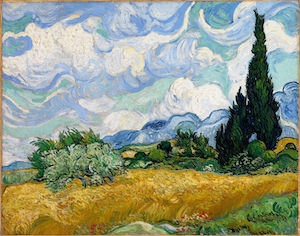

In [2]:
display(REFERENCE_IMAGE)

In [5]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [6]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    selection_name='tournament_4',
                    verbose=verbose_output)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

In [7]:
# %%time
# data = run_algorithm((0, 100, "ONE_POINT", 100, 'RANDOM', 500))

In [ ]:
# def population_analysis(start_size, end_size, default_settings, run_algo, n=10, thresh=120000):
#     pop_steps = np.linspace(start_size, end_size, n)
#     pop_results = []
#     for pop_step in pop_steps:
#         default_settings[1] = int(pop_step)
#         print("pop_step : ", pop_step)
#         data = run_algo(default_settings)
#         df = pd.DataFrame(data)
#         df["time-elapsed"] = df["time-elapsed"].round(0)
#         try:
            
#             index = np.argmax(df["best-fitness"] < thresh)
#             print(df["best-fitness"] < thresh)
#             first_app = index
#         except ValueError:
#             first_app = -1
#         pop_results.append(first_app)

#     plt.plot(pop_steps, pop_results)
    
#     out_arr = np.array([[*pop_steps], [*pop_results]])
#     out_filename = "pop_analysis.npy"
#     with open(out_filename, 'wb') as f:
#         np.save(f, out_arr)

#     return out_arr

def population_analysis(default_settings, run_algo, \
                            thresh_range=(1000, 1000000), thresh_mode='exp', thresh_n=10, 
                            pop_range=(20, 200), pop_mode='linear', pop_n=10):
    # Define threh range
    if thresh_mode == 'linear':
        thresh_steps = np.linspace(*thresh_range, thresh_n)
    elif thresh_mode == 'exp':
        thresh_steps = np.logspace(np.log10(thresh_range[0]), np.log10(thresh_range[1]), num=thresh_n)
        
    # Define population range
    if pop_mode == 'linear':
        pop_steps = np.linspace(*pop_range, pop_n)
    elif pop_mode == 'exp':
        pop_steps = np.logspace(np.log10(pop_range[0]), np.log10(pop_range[1]), num=pop_n)

    print(thresh_steps)
    print(pop_steps)
    
    out = np.zeros((2, thresh_n))
    out[0] = thresh_steps
    for thresh_idx, thresh in enumerate(thresh_steps):
        pop_found = False
        pop_i = 0
        while not pop_found and pop_i < len(pop_steps):
            # Set population in settings
            pop_step = pop_steps[pop_i]
            default_settings[1] = int(pop_step)
            
            data = run_algo(default_settings)
            df = pd.DataFrame(data)
            pop_fitness = np.min(df["best-fitness"])
            print(pop_fitness, thresh)
            if pop_fitness < thresh:
                out[1, thresh_idx] = pop_step
                pop_found = True
            pop_i += 1
        if not pop_found:
            out[1, thresh_idx] = -1
                

#     plt.plot(pop_steps, pop_results)
    
#     out_arr = np.array([[*pop_steps], [*pop_results]])
#     out_filename = "pop_analysis.npy"
#     with open(out_filename, 'wb') as f:
#         np.save(f, out_arr)

    return out

pop_out = population_analysis([0, 100, "ONE_POINT", 100, 'RANDOM', 10], run_algorithm)

[   1000.            2154.43469003    4641.58883361   10000.
   21544.34690032   46415.88833613  100000.          215443.46900319
  464158.88336128 1000000.        ]
[ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200.]
generation: 1 best fitness: 142761 avg. fitness: 145386.75
generation: 2 best fitness: 131948 avg. fitness: 140352.7
generation: 3 best fitness: 131948 avg. fitness: 135547.25
generation: 4 best fitness: 131325 avg. fitness: 132197.2
generation: 5 best fitness: 131126 avg. fitness: 131696.05
generation: 6 best fitness: 131126 avg. fitness: 131367.05
generation: 7 best fitness: 130313 avg. fitness: 131035.05
generation: 8 best fitness: 130048 avg. fitness: 130778.6
generation: 9 best fitness: 129702 avg. fitness: 130265.9
generation: 10 best fitness: 129614 avg. fitness: 129902.1
Done: run 0 - pop 20 - crossover ONE_POINT - num. points 100 - initialization RANDOM - in 2 seconds
129614 1000.0
generation: 1 best fitness: 136002 avg. fitness: 144654.725
generation: 2 best fit

In [19]:
print(pop_out)

[[1.00000e+06 1.25440e+10 4.97290e+10 1.11556e+11 1.98025e+11 3.09136e+11
  4.44889e+11 6.05284e+11 7.90321e+11 1.00000e+12]
 [2.00000e+01 2.00000e+01 2.00000e+01 2.00000e+01 2.00000e+01 2.00000e+01
  2.00000e+01 2.00000e+01 2.00000e+01 2.00000e+01]]


## Running a sweep of settings

In [6]:
%%time

generation_budget = 500
 
data = []
for seed in range(3):
    for population_size in (100,):
        for crossover_method in ("ONE_POINT",):
            for initialization in ("RANDOM",):
                for num_points in (100,):
                    data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, generation_budget)))

<multiprocess.pool.Pool state=RUN pool_size=4>
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 1 best fitness: 134707 avg. fitness: 143610.45
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 2 best fitness: 134273 avg. fitness: 139705.69
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 3 best fitness: 131336 avg. fitness: 136312.15
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 4 best fitness: 127039 avg. fitness: 134125.79
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 5 best fitness: 127039 avg. fitness: 131832.41
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 6 best fitness: 123294 avg. fitness: 129270.83
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 7 best fitness: 123294 avg. fitness: 127130.28
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 8 best fitness: 119067 avg. fitness: 125220.76
<multiprocess.pool.Pool state=RUN pool_size=4>
generation: 9 best fitness: 118781 avg. fitness: 123393.09

## Evaluating the results

In [7]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

In [26]:
df

,num-generations,num-evaluations,time-elapsed,best-fitness,crossover-method,population-size,num-points,initialization,seed
0,1,200,0.0,134707,ONE_POINT,100,100,RANDOM,0
1,2,300,1.0,134273,ONE_POINT,100,100,RANDOM,0
2,3,400,1.0,131336,ONE_POINT,100,100,RANDOM,0
3,4,500,1.0,127039,ONE_POINT,100,100,RANDOM,0
4,5,600,2.0,127039,ONE_POINT,100,100,RANDOM,0
...,...,...,...,...,...,...,...,...,...
1495,496,49700,218.0,48984,ONE_POINT,100,100,RANDOM,2
1496,497,49800,219.0,48821,ONE_POINT,100,100,RANDOM,2
1497,498,49900,219.0,48821,ONE_POINT,100,100,RANDOM,2
1498,499,50000,219.0,48773,ONE_POINT,100,100,RANDOM,2


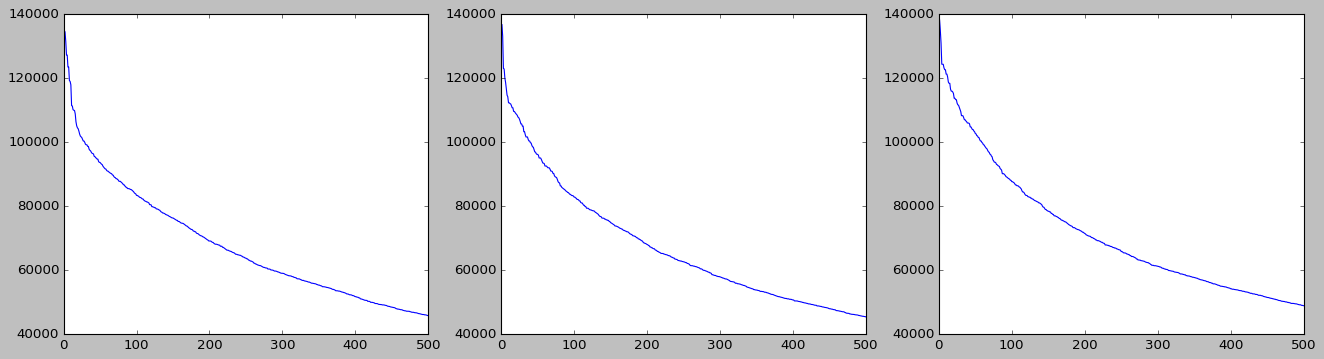

In [50]:
num_runs = 3
runs =  []
gb = generation_budget
for i in range(num_runs):
    runs.append(df[i*gb : (i+1)*gb])

fig, axs = plt.subplots(1, num_runs)
fig.set_figwidth(20)
fig.set_figheight(5)
for i in range(num_runs):
    sel = runs[i]
    
    # Plot on fitness on subplot
    axs[i].plot(sel['num-generations'], sel['best-fitness'])
    
# Show the figure
plt.show()

## Displaying the best instances over time

In [53]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

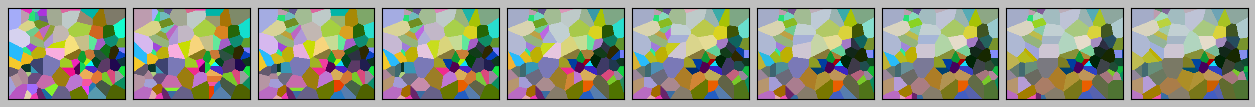

In [54]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, 'RANDOM', 500), grid=(1,10))